In [1]:
#pip install simpletransformers
import nltk
#nltk.download('punkt')

In [2]:
import nltk
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
import string
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split


In [3]:
# lowercase all text
df = pd.read_csv('cleaned_data.csv')
df['Text'] = df['Text'].str.lower()    # make everything lowercase
df.drop('Unnamed: 0', inplace=True, axis=1)
display(df)

,Text,Speaker
0,there's nothing to tell! he's just some guy i...,monica
1,"c'mon, you're going out with the guy! there's...",joey
2,so does he have a hump? a hump and a hairpiece?,chandler
3,"wait, does he eat chalk?",phoebe
4,"just, 'cause, i don't want her to go through ...",phoebe
...,...,...
52557,"no, no, no, no, no!",rachel
52558,"no, no, no, no, no!",phoebe
52559,"no, no, no, no, no!",joey
52560,"no, no, no, no, no!",chandler


In [4]:
df.rename(columns = {'Speaker':'labels'}, inplace = True)
for i in range(0,len(df)):
    speaker = df["labels"][i]
    if speaker =="monica":
        label = 0
    elif speaker =="phoebe":
        label = 1
    elif speaker =="rachel":
        label = 2
    elif speaker =="chandler":
        label = 3
    elif speaker =="joey":
        label = 4
    elif speaker =="ross":
        label = 5
    df.at[i,'labels']= label

In [5]:
df.reset_index(drop=True, inplace=True)
for i in range(1,len(df)):
    text = df["Text"][i]
    label = df["labels"][i]
    if len(text) >= 128:
        df.drop(i, inplace=True)
        n = 255
        chunks = [text[i:i+n] for i in range(0, len(text), n)]  #split the string into strings that have smaller length
        for chunk in chunks:                     # words are not split nicely, but at least we can use the whole string
            df.append({"Text": chunk, "labels": label}, ignore_index = True)
            


In [6]:
train=df.sample(frac=0.9) #random state is a seed value
test=df.drop(train.index)

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

In [9]:
test_text = []
test.reset_index(drop=True, inplace=True)
for i in range(1,len(test)):
    text = test["Text"][i]
    test_text.append(text)



In [10]:
print(test_text)

[' never had that dream.', ' no.', " strip joint! c'mon, you're single! have some hormones!", ' and i just want a million dollars! ', " who wasn't invited to the wedding.", " well, maybe that's my decision. well, maybe i don't need your money. wait!! wait, i said maybe!!", " okay, look, this is probably for the best, y'know? independence. taking control of your life.", " joey, stop hitting on her! it's her wedding day!", ' maybe.', ' rach, wait, i can cancel...', '  are, are you okay? i mean, do you want me to stay?', " so rachel, what're you, uh... what're you up to tonight?", " oh, i wish i could, but i don't want to.", ' done with the bookcase!', ' you guys.', ' -leg?', ' ...yeah. yeah, i do.', " all right, kids, i gotta get to work. if i don't input those numbers,... it doesn't make much of a difference... ", " yeah, we all have jobs. see, that's how we buy stuff.", " so how you doing today? did you sleep okay? talk to barry? i can't stop smiling.", ' oh, how well you know me...', 

In [82]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)


In [83]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch


Each epoch will have 1,223 steps.


In [84]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=6, args=model_args, use_cuda=False) # CUDA is disabled

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [77]:
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/39121 [00:00<?, ?it/s]

C:\Users\rensk\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/1223 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/15 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

{'mcc': 0.0, 'eval_loss': 1.0616459846496582}

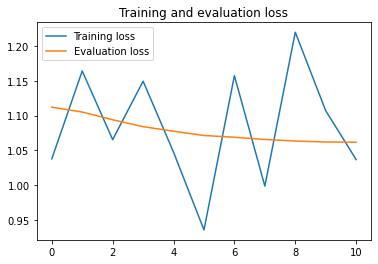

In [17]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()


# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

In [ ]:
test_text = []
test.reset_index(drop=True, inplace=True)
for i in range(1,len(test)):
    text = test["Text"][i]
    test_text.append(text)

In [18]:
predicted, probabilities = model.predict(test_text)
test['predicted'] = predicted

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
print(classification_report(test['labels'], test['predicted']))

In [22]:
try_to_predict = ['Hi Joey!']
predicted, probabilities = model.predict(try_to_predict)
print(predicted)
print(probabilities)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[1]
[[-0.45237207 -0.14954121 -0.16316196]]


In [34]:
# save model
import torch
torch.save(model, 'bert_model_big.pth')
saved_model = torch.load('bert_model_big.pth')


In [35]:
saved_model.predict(try_to_predict)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

([1], array([[-0.45237207, -0.14954121, -0.16316196]]))